<a href="https://colab.research.google.com/github/igenhimel/New-folder/blob/master/NUMTADB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.makedirs("dataset/NUMTA")

FileExistsError: ignored

In [6]:
!cp "/content/drive/My Drive/Colab Notebooks/Datasets/NUMTA.zip" dataset/NUMTA.zip

In [7]:
!unzip dataset/NUMTA.zip -d dataset/NUMTA

Archive:  dataset/NUMTA.zip
replace dataset/NUMTA/testing-a/a00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
None


In [8]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import time
import copy

#import pyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets,transforms,models

#Import matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image



In [9]:
#Hyperparameters
batch_size=256
num_iter=3200
input_shape=28*28 #num_features=784
output_shape=10
learning_rate=0.001

#Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
PATH = 'dataset/NUMTA/'
TRAIN_PATH = "dataset/NUMTA/training-a/"
TEST_PATH = 'dataset/NUMTA/testing-a/'
os.listdir(PATH)

['testing-c',
 'testing-all-corrected',
 'training-d.csv',
 'training-a',
 'training-b.csv',
 'training-b',
 'testing-auga',
 'testing-a',
 'training-c.csv',
 'training-c',
 'testing-f',
 'training-e',
 'testing-augc',
 'training-a.csv',
 'testing-d',
 'testing-e',
 'training-d',
 'training-e.csv',
 'testing-b']

In [11]:
class CustomDataset(Dataset):
  def __init__(self,df,root,transform=None):
    self.data=df
    self.root=root
    self.transform=transform

  def __len__(self):
    return len(self.data)
  def __getitem__(self,index):
    item = self.data.iloc[index]
    path = self.root+"/"+item[0]
    image=Image.open(path).convert('L')
    label=item[1]

    if self.transform is not None:
      image = self.transform(image)

    return image,label

In [12]:
a_csv = pd.read_csv(PATH+"training-a.csv")[['filename','digit']]
a_csv.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [13]:
mean = [0.5,]
std = [0.5,]

transform = test_transform = transforms.Compose([
                                transforms.Resize(28),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)
                                ])

In [16]:
train_dataset = CustomDataset(a_csv,TRAIN_PATH,transform)

In [17]:
len(train_dataset)

19702

#Data Spliting

In [18]:
#split data 20% for validation
val_size = 0.2

#obtain training indices that will be used for validation
dataset_size = len(train_dataset)

#mix data
#indices of all data
indices = list(range(dataset_size))

#random the index
np.random.shuffle(indices)

split=int(np.floor(val_size*dataset_size))

#divided into two part

train_idx,val_idx = indices[split:],indices[:split]

In [19]:
#define the sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

print("Train Sample: ",len(train_idx))
print("validation Sample: ",len(val_idx))

Train Sample:  15762
validation Sample:  3940


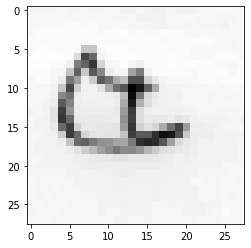

In [20]:
show_img = train_dataset[0][0].numpy().reshape(28,28)
plt.imshow(show_img,cmap='gray')

In [21]:
train_dataset[0][1]

5

#DataLoader

In [22]:
#Making Dataset Iterable

#Prepare loaders

train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
val_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=val_sampler)

In [23]:
image,label = next(iter(val_loader))
image.shape,label.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [24]:
torch.flatten(image,1,3).shape
image.view(image.shape[0],-1).shape

torch.Size([256, 784])

#FCN Model

In [25]:
class FC(nn.Module):
  def __init__(self,input_size,num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size,512) #input Layer
    self.fc2 = nn.Linear(512,256) # Hidden Layer
    self.fc3 = nn.Linear(256,128) #Hidden Layer
    self.fc4 = nn.Linear(128, num_classes)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    #probas = F.log_softmax(self.fc4(x), dim=1)
    logits = self.fc4(x)

    return logits  

In [26]:
#INSTANTIATE MODEL CLASS

model = FC(input_size=input_shape,num_classes=output_shape)

#To enable GPU
model.to(device)

FC(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

#Optimizer and Loss Function

In [27]:
#INSTATIATE OPTIMIZER CLASS

optimizer1 = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion1 = nn.CrossEntropyLoss()

#Batch Size,Epochs,Iterations

In [28]:
num_batches = (len(train_idx)/batch_size)
num_epochs  = num_iter / num_batches
num_epochs  = int(num_epochs)

print(f'Total Epochs: {num_epochs}')

Total Epochs: 51


In [29]:
dataloaders = {'train':train_loader,'val':val_loader}
dataset_size = {'train':len(train_idx),'val':len(val_idx)}

#Training

In [30]:
def train_model(model,criterion,optimizer,num_epochs=25,name='fc'):
    since = time.time()

    all_train_loss = []
    all_val_loss = []
    all_train_acc = []
    all_val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(0,num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs - 1))
        print('-' * 10)

        #Each epoch has a training and validation phase

        for phase in ['train','val']:
            if phase == 'train':
                model.train() #set model to training mode
            else:
                model.eval()  #set model to evaluate mode
      
            running_loss = 0.0  
            running_corrects = 0

            #Iterate over data.
            for inputs,labels in dataloaders[phase]:
               inputs = inputs.to(device)
               labels = labels.to(device)

               #forward
               #track history if only in train

               with torch.set_grad_enabled(phase == 'train'):
                   outputs = model(inputs)
                   _,preds = torch.max(outputs,1)
                   loss = criterion(outputs,labels)
     
                   #backward + optimize only if in training phase
                   if phase == 'train':

                       loss.backward()
                       optimizer.step()
                       optimizer.zero_grad()
        
               #statistics
               running_loss += loss.item() * inputs.size(0)
               running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            if phase == 'train':
              all_train_loss.append(epoch_loss)
              all_train_acc.append(epoch_acc.item())
            elif phase == 'val':
              all_val_loss.append(epoch_loss)
              all_val_acc.append(epoch_acc.item())

            print('{} Loss {:.4f} Acc: {:.4f}'.format(
              phase,epoch_loss,epoch_acc))
    
           #deep copy the model

        if phase == 'val' and epoch_acc>best_acc:
               best_acc = epoch_acc
               best_model_wts = copy.deepcopy(model.state_dict())
  
    print()

    time_elapsed = time.time() - since
    print('Training Complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60,time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
 
    #plotting the training and validation loss
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    axs[0].plot(all_train_loss,label='Training Loss')
    axs[0].plot(all_val_loss,label='validation Loss')
    axs[0].set_label("Training VS. Validation Loss")
    axs[0].set(xlabel="Epochs",ylabel="Loss")

    #plotting the training and validation loss
    axs[1].plot(all_train_acc,label='Training Accuracy')
    axs[1].plot(all_val_acc,label='Validation Accuracy')
    axs[1].set_label("Training VS. Validation Accuracy")
    axs[1].set(xlabel="Epochs",ylabel="Accuracy")

    axs[0].legend()
    axs[1].legend()

    #fig.tight_layout()
    plt.show()
    return model



Epoch 0/24
----------
train Loss 2.2987 Acc: 0.1093
val Loss 2.2830 Acc: 0.1147
Epoch 1/24
----------
train Loss 2.2121 Acc: 0.1813
val Loss 2.1131 Acc: 0.2736
Epoch 2/24
----------
train Loss 2.0030 Acc: 0.2935
val Loss 1.8841 Acc: 0.3424
Epoch 3/24
----------
train Loss 1.7899 Acc: 0.3813
val Loss 1.6352 Acc: 0.4464
Epoch 4/24
----------
train Loss 1.6874 Acc: 0.4106
val Loss 1.5709 Acc: 0.4612
Epoch 5/24
----------
train Loss 1.5388 Acc: 0.4623
val Loss 1.4363 Acc: 0.5203
Epoch 6/24
----------
train Loss 1.4681 Acc: 0.4880
val Loss 1.3632 Acc: 0.5383
Epoch 7/24
----------
train Loss 1.4168 Acc: 0.5045
val Loss 1.3930 Acc: 0.5003
Epoch 8/24
----------
train Loss 1.3762 Acc: 0.5244
val Loss 1.3672 Acc: 0.5371
Epoch 9/24
----------
train Loss 1.2788 Acc: 0.5654
val Loss 1.1888 Acc: 0.6132
Epoch 10/24
----------
train Loss 1.2487 Acc: 0.5750
val Loss 1.5974 Acc: 0.4353
Epoch 11/24
----------
train Loss 1.2458 Acc: 0.5735
val Loss 1.1255 Acc: 0.6360
Epoch 12/24
----------
train Loss 1.15

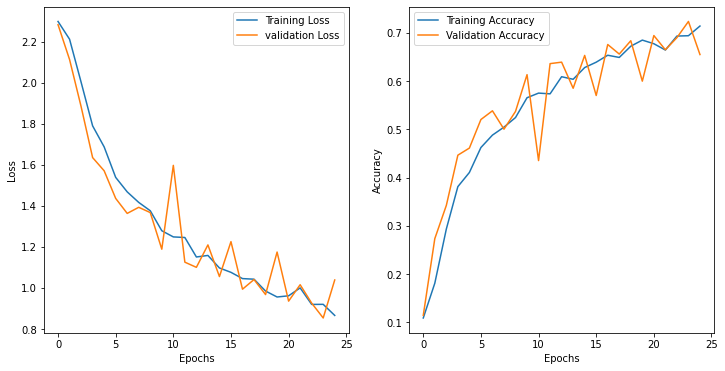

In [31]:
model = train_model(model,criterion1,optimizer1,num_epochs=25,name='fc')

In [32]:
!pip install jovian --upgrade --quiet

[y]
     |████████████████████████████████| 68 kB 7.4 MB/s 


In [33]:
import jovian

In [34]:
jovian.commit(project="NUMTADB")

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab
